In [ ]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
import h5py
import math

np.random.seed(4)

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.decomposition import PCA

from joblib import Parallel, delayed
from skimage.io import imread

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler
from canon.pattern import LatentExtractor
from canon.util import split_workload
from canon.autoencode.report import is_using_gpu

PARALLELISM = 1 if is_using_gpu() else -1

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key, thres=0)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

def process_img(img_files, model_name, batch_size=64):
    """
    img_files: list of file paths
    model_name: name passed to LatentExtractor
    batch_size: how many images to process at once
    """
    extractor = LatentExtractor(model_name)
    all_results = []

    total_batches = math.ceil(len(img_files) / batch_size)
    print(f"Total images: {len(img_files)}, batch size: {batch_size}, total batches: {total_batches}")

    for batch_idx in range(total_batches):
        start = batch_idx * batch_size
        batch_files = img_files[start:start + batch_size]

        print(f"Processing batch {batch_idx + 1}/{total_batches} (files {start}–{start + len(batch_files) - 1}) ...", end=" ")

        # load batch into a single array (N, H, W, …)
        img_data = np.stack([imread(f) for f in batch_files], axis=0)

        # extract the index from filename
        img_idx = np.array([[int(f[-9:-4])] for f in batch_files])

        # get latent codes for this batch
        codes = extractor.features(img_data)

        # combine idx + codes
        batch_res = np.hstack([img_idx, codes])
        all_results.append(batch_res)

        print("done")

    # concatenate all batches
    if all_results:
        result = np.vstack(all_results)
    else:
        # no files: return empty array with correct number of columns
        dummy = extractor.features(np.empty((0,) + img_data.shape[1:]))
        result = np.empty((0, 1 + dummy.shape[1]))

    print(f"Finished processing all batches; final result shape {result.shape}")
    return result

def extract_features(jpg_dir, model_name,n_workers=8):
    dir_path = os.path.join("img", jpg_dir)
    filenames = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)
                 if (not filename[0] == '.') and filename[-4:] == ".jpg"]
    print('Found %d files in the directory %s.' % (len(filenames), dir_path))

    if PARALLELISM == 1 and not model_name.startswith("ae_"):
        data = process_img(filenames, model_name, batch_size=256)
        data = data[data[:,0].argsort()]
    else:
        fn_grps = split_workload(filenames, 64)
        with Parallel(n_jobs=PARALLELISM, verbose=1) as parallel:
            data = parallel(delayed(process_img)(grp, model_name) for grp in fn_grps)
            data = np.vstack(data)
    data = data[data[:,0].argsort()]
    print("Loaded a data of shape {}".format(data.shape))
    
    return data

2025-06-05 21:27:51.152498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 21:27:51.178027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 21:27:51.184882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 21:27:51.206876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1749184073.106540  3250

## Feature Extraction

In [ ]:
t0 = time.time()

jpg_dir = "ratio4_TF2"
# jpg_dir = "Au324_RT"

models = ["ae_conv_4_256_best"]
# models = ["resnet50_256"]

features = []
for model in models:
    print("Extracting features from {} using {} ...".format(jpg_dir, model))
    data = extract_features(jpg_dir, model)
    features.append(data)

hdf5_file = jpg_dir +'.hdf5'
print("Save {} datasets to {}".format(len(features), hdf5_file))
with h5py.File(os.path.join("features", hdf5_file), 'w') as h5f:
    for m, d in zip(models, features):
        print(m, d.shape)
        h5f.create_dataset(m, data=d)
with h5py.File(os.path.join("features", hdf5_file), 'r') as h5f:
    print("Final datasets in {}: {}".format(hdf5_file, list(h5f.keys())))
    
print("%.2f" % (time.time() - t0))

Extracting features from ratio4_TF2 using ae_conv_4_256_best ...
Found 10000 files in the directory img/ratio4_TF2.


I0000 00:00:1749184074.286480  325023 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1749184074.286652  325023 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1749184074.286713  325023 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1749184074.593938  325023 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1749184074.594106  325023 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-05

Total images: 10000, batch size: 256, total batches: 40
Processing batch 1/40 (files 0–255) ... 

I0000 00:00:1749184102.123720  330318 service.cc:146] XLA service 0x7913c8006510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749184102.123772  330318 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-05 21:28:22.132182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-05 21:28:22.159175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90800


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


I0000 00:00:1749184103.160484  330318 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
done
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
done
8/8 ━

In [11]:
feature_file="ratio4_TF2"
img_shape = (100, 100)
aspect_ratio = 1
seqs = ["ratio4_TF2"]

ae_models = []
features = []
data1 = []
with h5py.File(os.path.join("features", feature_file +'.hdf5'), 'r') as h5f:
    for k in h5f.keys():
        print(k)
        data = np.array(h5f.get(k))
        print(data.shape)
        features.append(fill_features(data, img_shape))
        ae_models.append(k)
    data1 = data

resnet50_256
(10000, 257)


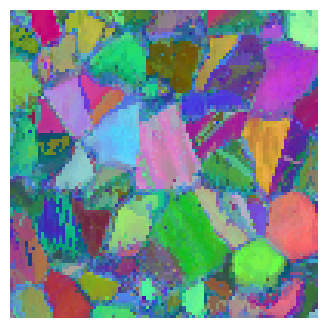

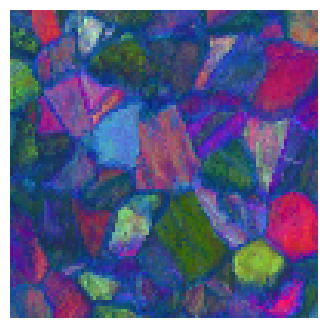

In [12]:
from sklearn.manifold import TSNE

def draw_direct_color_tsne(features, ax, img_shape=(150,150),n_components=10):
    # Reduce dimensionality with PCA to 10 for better performance with t-SNE
    pca = PCA(n_components=10)
    pca_result = pca.fit_transform(features)
    
    # Further reduce dimensionality to 3 with t-SNE for RGB colors
    tsne = TSNE(n_components=3, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)
    
    # Normalize t-SNE results to [0, 1] for valid RGB values
    tsne_result_norm = (tsne_result - np.min(tsne_result, axis=0)) / (np.max(tsne_result, axis=0) - np.min(tsne_result, axis=0))
    
    # Reshape t-SNE result to form an image
    Z = np.zeros((img_shape[0] * img_shape[1], 3))
    Z[:, 0] = tsne_result_norm[:, 0]
    Z[:, 1] = tsne_result_norm[:, 1]
    Z[:, 2] = tsne_result_norm[:, 2]
    img = Z.reshape(img_shape[0], img_shape[1], 3)
    
    # Plot the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes ticks
    return img, tsne_result

def draw_direct_color_pca(features, ax, img_shape=(150,150)):
    # Directly reduce dimensionality to 3 with PCA for RGB colors
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(features)
    
    # Normalize PCA results to [0, 1] for valid RGB values
    pca_result_norm = (pca_result - np.min(pca_result, axis=0)) / (np.max(pca_result, axis=0) - np.min(pca_result, axis=0))
    
    # Reshape PCA result to form an image
    Z = np.zeros((img_shape[0] * img_shape[1], 3))
    Z[:, 0] = pca_result_norm[:, 0]
    Z[:, 1] = pca_result_norm[:, 1]
    Z[:, 2] = pca_result_norm[:, 2]
    img = Z.reshape(img_shape[0], img_shape[1], 3)
    
    # Plot the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes ticks
    return img, pca_result
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
img_dc, tsne_result = draw_direct_color_tsne(data[:,1:], ax,n_components=10, img_shape=(100,100))
fig.savefig('tsne_result_ratio4_TF2.png')  # Save the figure as PNG
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
img_dc, tsne_result = draw_direct_color_pca(data[:,1:], ax, img_shape=(100,100))
fig.savefig('pca_result_ratio4_TF2.png')  # Save the figure as PNG